In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
# from transformers import SegformerForSemanticSegmentation
import torch
from torch import nn
import numpy as np
from torchinfo import summary
from helper.models.unet import *
from helper.models.deeplab_mobilenet import *
from helper.models.nvidia_ade20k import *
import matplotlib.pyplot as plt
%matplotlib inline


g:\Universe\Materials\Github Repos\Drainage-detection-topography\.venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
unetmodel = UNet.load_model("Unet-20250504-172328.pt")

In [5]:
from engine.data_setup import *

In [12]:
dataset = get_dataset(mode='test', name='ver7', channels=4)

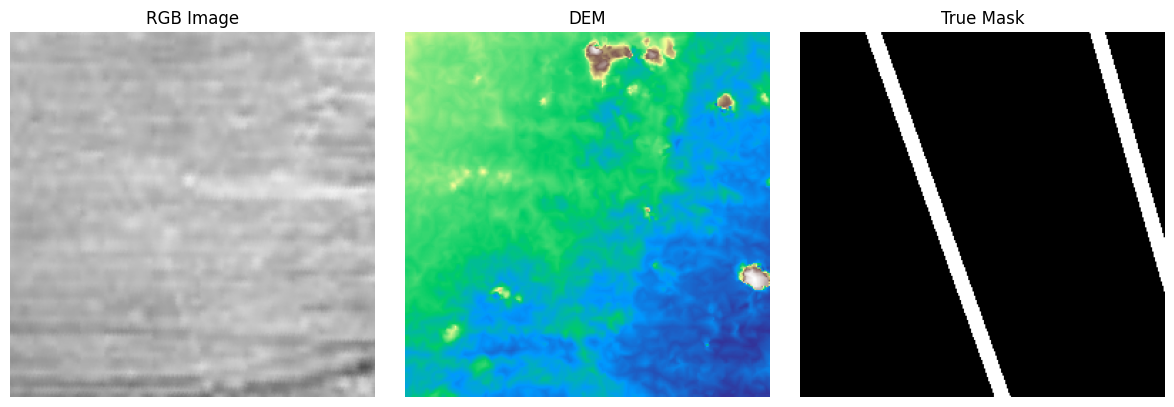

In [16]:
dataset.show(2)

In [13]:
unetmodel.predict(dataset[10][0], dataset[10][1], device='cuda', show=True, show_full=False)

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 4, 256, 256] to have 3 channels, but got 4 channels instead

In [15]:
# Important: 34
nonzero_masks = [i for i in range(len(dataset)) if dataset[i][1].sum() != 0]
nonzero_masks

[0,
 2,
 5,
 8,
 10,
 14,
 19,
 21,
 28,
 34,
 42,
 43,
 52,
 55,
 56,
 57,
 58,
 62,
 63,
 66,
 72,
 75,
 76,
 81,
 82,
 87,
 88,
 89,
 106,
 107,
 111,
 112,
 118,
 123,
 130,
 136,
 139,
 145,
 148,
 149,
 160,
 161,
 163]

### Plot

In [44]:
plot_model = UNet.load_model("Unet-20250428-185653.pt")

In [27]:
plot_dataset = get_dataset(name='dataset_plot_light', mode='test', channels=3)

In [28]:
nonzero_masks = [i for i in range(len(plot_dataset)) if plot_dataset[i][1].sum() != 0]
nonzero_masks

[0,
 1,
 2,
 3,
 5,
 9,
 10,
 12,
 13,
 14,
 16,
 20,
 21,
 24,
 28,
 29,
 31,
 32,
 37,
 41,
 43,
 44,
 46,
 49,
 50,
 54,
 56,
 57,
 59,
 62,
 69,
 70,
 71,
 74,
 77,
 78,
 79,
 82,
 85,
 86,
 87,
 95,
 96,
 104,
 106,
 108,
 109,
 111,
 112,
 113,
 114,
 116,
 117,
 118,
 119,
 122,
 125,
 126,
 127,
 131,
 132,
 137,
 142,
 143,
 145,
 148]

mask: torch.Size([256, 256])
inter: torch.Size([256, 256])


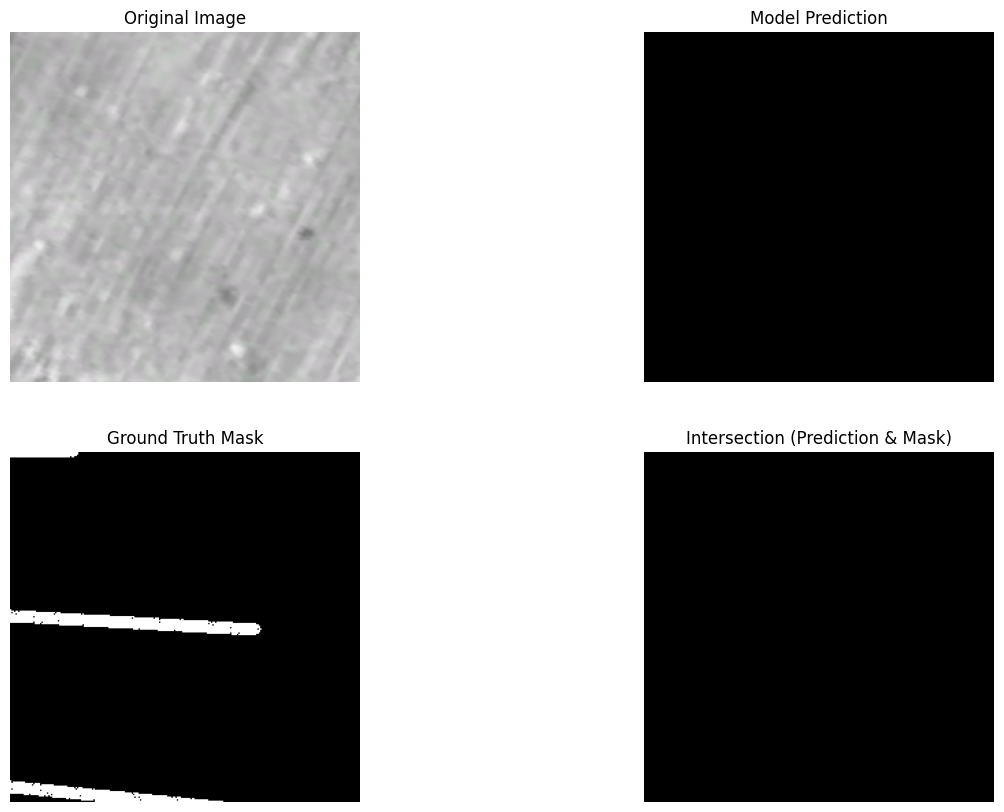

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [43]:
model.predict(plot_dataset[20][0], plot_dataset[20][1], device='cuda', show=True, show_full=True)